# Generalized CP (GCP) Tensor Decomposition

```
Copyright 2022 National Technology & Engineering Solutions of Sandia,
LLC (NTESS). Under the terms of Contract DE-NA0003525 with NTESS, the
U.S. Government retains certain rights in this software.
```

This document outlines usage and examples for the generalized CP (GCP) tensor decomposition implmented in `pyttb.gcp_opt`. GCP allows alternate objective functions besides sum of squared errors, which is the standard for CP. The code support both dense and sparse input tensors, but the sparse input tensors require randomized optimization methods.

GCP is described in greater detail in the manuscripts:
* D. Hong, T. G. Kolda, J. A. Duersch, Generalized Canonical Polyadic Tensor Decomposition, SIAM Review, 62:133-163, 2020, https://doi.org/10.1137/18M1203626
* T. G. Kolda, D. Hong, Stochastic Gradients for Large-Scale Tensor Decomposition. SIAM J. Mathematics of Data Science, 2:1066-1095, 2020, https://doi.org/10.1137/19m1266265

## Basic Usage
The idea of GCP is to use alternative objective functions. As such, the most important thing to specify is the objective function.

The command 
```
M = ttb.gcp_opt(data=X, rank=rank, objective=Objectives.<TYPE>, optimizer=<OPT>)
``` 
computes an estimate of the best rank-$R$ generalized CP (GCP) decomposition of the tensor `X` for the specified generalized loss function specified by `<TYPE>` solved with optimizer `<OPT>`. The input `X` can be a tensor or sparse tensor. The result `M` is a Kruskal tensor. 

Predefined objective functions are:

* `GAUSSIAN`: Gaussian distribution (see also `cp_als` and `cp_opt`)
* `BERNOULLI_ODDS`: Bernoulli distribution for binary data
* `BERNOULLI_LOGIT`: Bernoulli distribution for binary data with log link
* `POISSON`: Poisson distribution for count data (see also `cp_apr`)
* `POISSON_LOG`: Poisson distribution for count data with log link
* `RAYLEIGH`: Rayleigh distribution for nonnegative continuous data
* `GAMMA`: Gamma distribution for nonnegative continuous data
* `HUBER`: Similar to Gaussian but robust to outliers
* `NEGATIVE_BINOMIAL`: Models the number of trials required before we experience some number of failures. May be a useful alternative when Poisson is overdispersed.
* `BETA`: Generalizes exponential family of loss functions.

Alternatively, a user can supply one's own objective function as a tuple of `function_handle`, `gradient_handle`, and `lower_bound`.

Supported optimizers are:
* `LBFGSB`: bound-constrained limited-memory BFGS (L-BFGS-B). L-BFGS-B can only be used for dense tensors.
* `SGD`: Stochastic gradient descent (SGD). Can be used with both dense and sparse tensors.
* `Adagrad`: Adaptive gradients SGD method. Can be used with both dense and sparse tensors.
* `Adam`: Momentum-based SGD method. Can be used with both dense and sparse tensors.

Each methods has parameters, which are described below.

## Specifying Missing or Incomplete Data Using the Mask Option
If some entries of the tensor are unknown, the method can mask off that data during the fitting process. To do so, specify a *mask* tensor `W` that is the same size as the data tensor `X`. The mask tensor should be 1 if the entry in `X` is known and 0 otherwise. The call is 
```
M = ttb.gcp_opt(data=X, rank=rank, objective=Objectives.<TYPE>, optimizer=LBFGSB, mask=W)
```
Note: that `mask` isn't supported for stochastic solves.

## Solver options
Defaults are listed in brackets {}

Common options that can be passed to `pyttb.gcp_opt()` include:

* `init`: Initial solution to the problem {"random"}.
* `printitn`: Controls verbosity of printing throughout the solve: print every n iterations; 0 for no printing.
* `sampler`: Class that defined sampling strategy for stochastic solves.

## Other Options
In addition to the options above, the behavior of optimizers can be affected by constructing the optimizer with the following optional parameters.

### Specifying L-BFGS-B Parameters
* `m`: {None}
* `factr`: Tolerance on the change on the objective value. Defaults to 1e7, which is multiplied by machine epsilon. {1e7}
* `pgtol`: Projected gradient tolerance, defaults to 1e-4 times total tensor size. It can sometimes be useful to increase or decrease `pgtol` depending on the objective function and size of the tensor. {None}
* `epsilon`: {None}
* `iprint`: {None}
* `disp`: {None}
* `maxfun`: {None}
* `maxiter`: {1000}
* `callback`: {None}
* `maxls`: {None}

### Specifying SGD, Adagrad, and ADAM Parameters
There are a number of parameters that can be adjusted for SGD and ADAM.

#### Stochastic Gradient
There are three different sampling methods for computing the stochastic gradient:

* Uniform - Entries are selected uniformly at random. Default for dense tensors.
* Stratified - Zeros and nonzeros are sampled separately, which is recommended for sparse tensors. Default for sparse tensors.
* Semi-Stratified - Modification to stratified sampling that avoids rejection sampling for better efficiency at the cost of potentially higher variance.

The options corresponding to these are as follows.

* `gradient_sampler`: Type of sampling to use for stochastic gradient. Specified by setting `pyttb.gcp.samplers.<SAMPLER>`. Predefined options for `<SAMPLER>` are:
    * `Samplers.UNIFORM`: default for dense.
    * `Samplers.STRATIFIED`: default for sparse.
    * `Samplers.SEMISTRATIFIED`
* `gradient_samples`: The number of samples for stochastic gradient can be specified as either an `int` or a `StratifiedCount` object. This should generally be $O(R\sum_{k=1}^d n_k)$, where $n_k$ is the number of rows in the $k$-th mode and $R$ is the target rank. For the uniform sampler, only an `int` can be provided. For the stratified or semi-stratified sampler, this can be two numbers `a, b` provided as arguments to a `pyttb.gcp.samplers.StratifiedCount(a, b)` object. The first `a` is the number of nonzero samples and the second `b` is the number of zero samples. If only one number is specified, then this is used as the number for both nonzeros and zeros, and the total number of samples is 2x what is specified.

#### Estimating the Function.

We also use sampling to estimate the function value.

* `function_sampler`: This can be any of the three samplers specified above or a custom function handle. The custom function handle is primarily useful in reusing the same sampled elements across different tests.
* `function_samples`: Number of samples to estimate function. As before, the number of samples for estimating the function can be specified as either an `int` or a `StratifiedCount` object. This should generally be somewhat large since we want this sample to generate a reliable estimate of the true function value.

Creating the sampler takes two additional options:
* `max_iters`: Maximum number of iterations to normalize number of samples. {1000}
* `over_sample_rate`: Ratio of extra samples to take to account for bad draws. {1.1}

There are some other options that are needed for SGD: the learning rate and a decrease schedule. Our schedule is very simple - we decrease the rate if there is no improvement in the approximate function value after an epoch. After a specified number of decreases (`max_fails`), we quit.

* `rate`: Rate of descent, proportional to step size. {1e-3}
* `decay`: How much to decrease step size on failed epochs. {0.1}
* `max_fails`: How many failed epochs before terminating the solve. {1}
* `epoch_iters`:  Number of steps to take per epoch. {1000}
* `f_est_tol`: Tolerance for function estimate changes to terminate solve. {-inf}
* `max_iters`: Maximum number of epochs. {1000}
* `printitn`: Controls verbosity of information during solve. {1}

There are some options that are specific to ADAM and generally needn't change:
* `beta_1`: Adam-specific momentum parameter beta_1. {0.9}
* `beta_2`: Adam-specific momentum parameter beta_2. {0.999}
* `epsilon`: Adam-specific momentum parameter to avoid division by zero. {1e-8}

In [ ]:
import os
import sys
import pyttb as ttb
import numpy as np
from pyttb.pyttb_utils import tt_tenfun

from pyttb.gcp.fg_setup import function_type, setup
from pyttb.gcp.handles import Objectives
from pyttb.gcp.optimizers import LBFGSB, SGD, Adagrad, Adam
from pyttb.gcp.samplers import GCPSampler

## Example with Gaussian distribution

In [ ]:
X = ttb.tenones((2, 2))
X[0, 1] = 0.0
X[1, 0] = 0.0
rank = 2

### Run GCP-OPT

In [ ]:
%%time
# Select Gaussian objective
objective = Objectives.GAUSSIAN

# Select LBFGSB solver with 2 max iterations
optimizer = LBFGSB(maxiter=2, iprint=1)

# Compute rank-2 GCP approximation to X with GCP-OPT
# Return result, initial guess, and runtime information
np.random.seed(0)  # Creates consistent initial guess
result_lbfgs, initial_guess, info_lbfgs = ttb.gcp_opt(
    data=X, rank=rank, objective=objective, optimizer=optimizer
)

print(
    f"\nFinal fit: {1 - np.linalg.norm((X-result_lbfgs.full()).double())/X.norm()} (for comparison to f(x) in CP-ALS)\n"
)

### Compare to CP-ALS, which should usually be faster

In [ ]:
%%time
result_als, _, info_als = ttb.cp_als(
    input_tensor=X, rank=rank, maxiters=2, init=initial_guess
)
print(
    f"\nFinal fit: {1 - np.linalg.norm((X-result_als.full()).double())/X.norm()} (for comparison to f(x) in GCP-OPT)\n"
)

### Now let's try is with the ADAM functionality

In [ ]:
%%time
# Select Gaussian objective
objective = Objectives.GAUSSIAN

# Select LBFGSB solver with 2 max iterations
optimizer = Adam(max_iters=2)

# Compute rank-2 GCP approximation to X with GCP-OPT
# Return result, initial guess, and runtime information
result_adam, _, info_adam = ttb.gcp_opt(
    data=X,
    rank=rank,
    objective=objective,
    optimizer=optimizer,
    init=initial_guess,
    printitn=1,
)
print(
    f"\nFinal fit: {1 - np.linalg.norm((X-result_adam.full()).double())/X.norm()} (for comparison to f(x) in GCP-OPT & CP-ALS)\n"
)

In [ ]:
# Inspect runtime information from each run
print(f"Runtime information from `gcp_opt_lbfgs`: \n{info_lbfgs}")
print(f"\nRuntime information from `cp_als`: \n{info_als}")
print(f"\nRuntime information from `gcp_opt_adam`: \n{info_adam}")

## Create an example Rayleigh tensor model and data instance.
Consider a tensor that is Rayleigh-distribued. This means its entries are all nonnegative. First, we generate such a tensor with low-rank structure.

In [ ]:
rng = np.random.default_rng(65)
rank = 3
shape = (50, 60, 70)
ndims = len(shape)

# Create factor matrices that correspond to smooth sinusidal factors
U = []
for k in np.arange(ndims):
    V = 1.1 + np.cos(
        (2 * np.pi / shape[k] * np.arange(shape[k])[:, np.newaxis])
        * np.arange(1, rank + 1)
    )
    U.append(V[:, rng.permutation(rank)])

M_true = ttb.ktensor(U).normalize()


def make_rayleigh(X):
    xvec = X.reshape((np.prod(X.shape), 1))
    rayl = rng.rayleigh(size=xvec.shape)
    yvec = rayl * xvec.data
    Y = ttb.tensor(yvec, shape=X.shape)
    return Y


X = make_rayleigh(M_true.full())

### Run GCP-OPT

In [ ]:
%%time
# Select Rayleigh objective
objective = Objectives.RAYLEIGH

# Select LBFGSB solver
optimizer = LBFGSB(maxiter=2, iprint=1)

# Compute rank-3 GCP approximation to X with GCP-OPT
result_lbfgs, initial_guess, info_lbfgs = ttb.gcp_opt(
    data=X, rank=rank, objective=objective, optimizer=optimizer, printitn=1
)

print(f"\nFinal fit: {1 - np.linalg.norm((X-result_lbfgs.full()).double())/X.norm()}\n")

### Now let's try is with the scarce functionality - this leaves out all but 10% of the data!

In [ ]:
# Select Rayleigh objective
objective = Objectives.RAYLEIGH

# Select Adam solver
optimizer = Adam(max_iters=2)

# Compute rank-3 GCP approximation to X with GCP-OPT
result_adam, initial_guess, info_adam = ttb.gcp_opt(
    data=X, rank=rank, objective=objective, optimizer=optimizer, printitn=1
)

print(f"\nFinal fit: {1 - np.linalg.norm((X-result_adam.full()).double())/X.norm()}\n")

## Boolean tensor.
The model will predict the odds of observing a 1. Recall that the odds related to the probability as follows. If $p$ is the probability and $r$ is the odds, then $r = p / (1-p)$. Higher odds indicates a higher probability of observing a one.

In [ ]:
rng = np.random.default_rng(7639)
rank = 3
shape = (60, 70, 80)
ndims = len(shape)

We assume that the underlying model tensor has factor matrices with only a few "large" entries in each column. The small entries should correspond to a low but nonzero entry of observing a 1, while the largest entries, if multiplied together, should correspond to a very high likelihood of observing a 1.

In [ ]:
probrange = np.array([0.01, 0.99])
oddsrange = probrange / (1 - probrange)
smallval = np.power(np.min(oddsrange) / rank, (1 / ndims))
largeval = np.power(np.max(oddsrange) / rank, (1 / ndims))

A = []
for k in np.arange(ndims):
    A.append(smallval * np.ones((shape[k], rank)))
    nbig = 5
    for j in np.arange(rank):
        p = rng.permutation(shape[k])
        A[k][p[: nbig - 1], j] = largeval

M_true = ttb.ktensor(A)

### Convert K-tensor to an observed tensor. Get the model values, which correspond to odds of observing a 1


In [ ]:
Mfull = M_true.double()
# Convert odds to probabilities
Mprobs = Mfull / (1 + Mfull)
# Flip a coin for each entry, with the probability of observing a one
# dictated by Mprobs
Xfull = 1.0 * (ttb.tenrand(shape) < Mprobs)
# Convert to sparse tensor, real-valued 0/1 tensor since it was constructed
# to be sparse
X = Xfull.to_sptensor()
print(f"Proportion of nonzeros in X is {100*X.nnz / np.prod(shape):.2f}%\n");

#### Just for fun, let's visualize the distribution of the probabilities in the model tensor.

ValueError: too many values to unpack (expected 2)

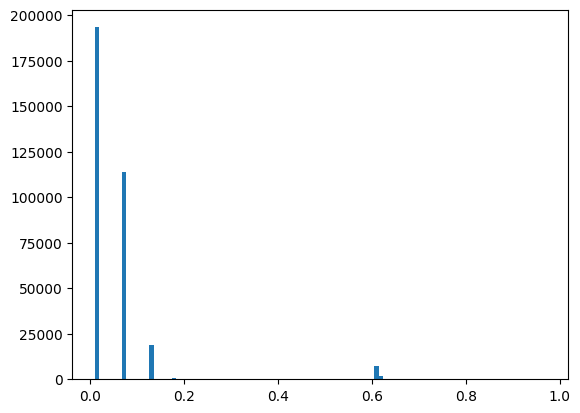

In [86]:
import matplotlib.pyplot as plt

h = plt.hist(Mprobs.flatten(),bins=100)


### Call GCP_OPT on the full tensor

In [ ]:
%%time
# Select Gaussian objective
objective = Objectives.BERNOULLI_ODDS

# Select LBFGSB solver
optimizer = LBFGSB(iprint=1, maxiter=2)

# Compute rank-3 GCP approximation to X with GCP-OPT
result_lbfgs, initial_guess, info_lbfgs = ttb.gcp_opt(
    data=Xfull, rank=rank, objective=objective, optimizer=optimizer
)

print(f"\nFinal fit: {1 - np.linalg.norm((X-result_lbfgs.full()).double())/X.norm()}\n")

### GCP-OPT as sparse tensor

In [ ]:
%%time
# Select Gaussian objective
objective = Objectives.BERNOULLI_ODDS

# Select LBFGSB solver
optimizer = Adam(max_iters=2)

# Compute rank-3 GCP approximation to X with GCP-OPT
result_adam, initial_guess, info_adam = ttb.gcp_opt(
    data=X, rank=rank, objective=objective, optimizer=optimizer, printitn=1
)

print(f"\nFinal fit: {1 - np.linalg.norm((X-result_adam.full()).double())/X.norm()}\n")

## Create and test a Poisson count tensor.

We follow the general procedure outlined by E. C. Chi and T. G. Kolda, On Tensors, Sparsity, and Nonnegative Factorizations, arXiv:1112.2414 [math.NA], December 2011 (http://arxiv.org/abs/1112.2414).

In [ ]:
# Pick the size and rank
sz = (10, 8, 6)
R = 5

# Generate factor matrices with a few large entries in each column
# this will be the basis of our solution.
np.random.seed(0)  # Set seed for reproducibility
A = []
for n in range(len(sz)):
    A.append(np.random.uniform(size=(sz[n], R)))
    for r in range(R):
        p = np.random.permutation(sz[n])
        nbig = round((1 / R) * sz[n])
        A[-1][p[0:nbig], r] *= 100
weights = np.random.uniform(size=(R,))
S = ttb.ktensor(A, weights)
S.normalize(sort=True, normtype=1)

X = S.to_tensor()
X.data = np.floor(np.abs(X.data))

### Loss function for Poisson negative log likelihood with identity link.

In [ ]:
%%time
# Select Gaussian objective
objective = Objectives.POISSON

# Select LBFGSB solver
optimizer = Adam(max_iters=2)

# Compute rank-3 GCP approximation to X with GCP-OPT
result_adam, initial_guess, info_adam = ttb.gcp_opt(
    data=X, rank=rank, objective=objective, optimizer=optimizer, printitn=1
)

print(f"\nFinal fit: {1 - np.linalg.norm((X-result_adam.full()).double())/X.norm()}\n")